In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


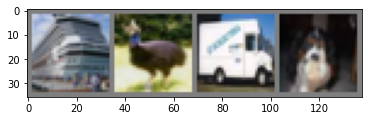

 ship  bird truck   dog


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [6]:
net = models.googlenet(pretrained=True)
# modify last layer for # of classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

net.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [7]:
pool_type = nn.MaxPool2d(kernel_size=2, stride=2)
#pool_type = nn.AvgPool2d(kernel_size=2, stride=2)

# list of modifications needed
modules_to_modify = [(name, module) for name, module in net.named_modules() if isinstance(module, nn.MaxPool2d) or isinstance(module, nn.AvgPool2d)]

# change pooling type
for name, module in modules_to_modify:
    setattr(net, name, pool_type)


In [8]:
# cross entropy for loss func
loss_func = nn.CrossEntropyLoss()  

#opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #using SGD as optimizer
opt = optim.Adam(net.parameters(), lr=0.001) #using adam as optimizer

In [9]:
# change act funct to sigmoid
for name, module in net.named_modules():
    if isinstance(module, nn.ReLU):
        setattr(net, name, nn.Sigmoid())
    #change to relu
    #if isinstance(module, nn.Sigmoid):
        #setattr(net, name, nn.ReLU())

In [10]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.367
[epoch: 0, i:   199] avg mini-batch loss: 2.316
[epoch: 0, i:   299] avg mini-batch loss: 2.291
[epoch: 0, i:   399] avg mini-batch loss: 2.243
[epoch: 0, i:   499] avg mini-batch loss: 2.353
[epoch: 0, i:   599] avg mini-batch loss: 2.243
[epoch: 0, i:   699] avg mini-batch loss: 2.246
[epoch: 0, i:   799] avg mini-batch loss: 2.283
[epoch: 0, i:   899] avg mini-batch loss: 2.201
[epoch: 0, i:   999] avg mini-batch loss: 2.195
[epoch: 0, i:  1099] avg mini-batch loss: 2.198
[epoch: 0, i:  1199] avg mini-batch loss: 2.167
[epoch: 0, i:  1299] avg mini-batch loss: 2.171
[epoch: 0, i:  1399] avg mini-batch loss: 2.129
[epoch: 0, i:  1499] avg mini-batch loss: 2.186
[epoch: 0, i:  1599] avg mini-batch loss: 2.218
[epoch: 0, i:  1699] avg mini-batch loss: 2.209
[epoch: 0, i:  1799] avg mini-batch loss: 2.134
[epoch: 0, i:  1899] avg mini-batch loss: 2.078
[epoch: 0, i:  1999] avg mini-batch loss: 2.060
[epoch: 0, i:  2099] avg mini-batch loss

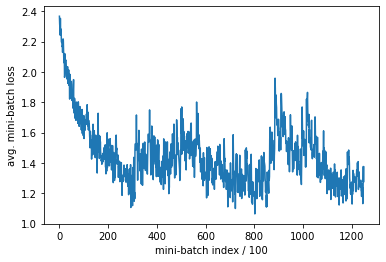

In [11]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

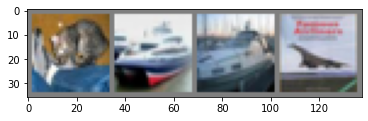

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship   car plane


In [12]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [13]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


In [14]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 52 %
Accuracy of  bird : 47 %
Accuracy of   cat : 27 %
Accuracy of  deer : 39 %
Accuracy of   dog : 34 %
Accuracy of  frog : 59 %
Accuracy of horse : 62 %
Accuracy of  ship : 66 %
Accuracy of truck : 64 %
